# Multi Layer (3 hidden, 1 output) Simple Recurrent Network (SRN, Elman 1990) applied to sMNIST
## This code uses flax.linen.scan to speed up the loop over time

## Equations
State update:

$
\vec{h}_t^1 = \tanh(W_{hx}^1\vec{x}_t + W_{hh}^1\vec{h}_{t-1}^1 + \vec{b}_h^1) \text{ with }\vec{h}_t^1 \in \mathbb{R}^{n_h} \text{ and } \vec{x}_t \in \mathbb{R}^{n_x} \\
\vec{h}_t^2 = \tanh(W_{hx}^2\vec{h}_t^1 + W_{hh}^2\vec{h}_{t-1}^2 + \vec{b}_h^2) \text{ with }\vec{h}_t^2 \in \mathbb{R}^{n_h} \\
\vec{h}_t^3 = \tanh(W_{hx}^3\vec{h}_t^2 + W_{hh}^3\vec{h}_{t-1}^2 + \vec{b}_h^3) \text{ with }\vec{h}_t^3 \in \mathbb{R}^{n_h} \\
$

Output: mean of output over time (or cummulative sum of output over time):

$
\vec{o}_t = W_{hy}\vec{h}_t^3 + \vec{b}_o \\
\vec{o} = \frac{1}{T}\sum_{t=1}^{T}\vec{o}_t \\
\vec{y} = \text{softmax}(\vec{o}) \\
$

In [1]:
!pwd
!which python
!pip freeze | grep -E 'flax|jax|orbax|optax'

/home/tristan/LearningJAX/Flax
/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/bin/python
flax==0.8.0
jax==0.4.25
jaxlib==0.4.25+cuda11.cudnn86
optax==0.1.8
orbax-checkpoint==0.5.0


In [1]:
import jax
import numpy as np
import torch
from jax import numpy as jnp
from torch.utils.data import TensorDataset
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from flax import linen as nn
from flax.training import train_state
import optax
from jax.nn.initializers import lecun_normal
from typing import Any, Tuple, Sequence, Optional
import matplotlib.pyplot as plt
px = 1 / plt.rcParams['figure.dpi']

jnp.set_printoptions(precision=3, suppress=True)

# set cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
# WARNING: this code is from QSSM project and won't be updated 
def create_mnist_classification_dataset(bsz=128, root="./data", version="sequential"):
    print("[*] Generating MNIST Classification Dataset...")
    assert version in ["sequential", "row"], "Invalid version for MNIST dataset"

    # Constants
    if version == "sequential":
        SEQ_LENGTH, N_CLASSES, IN_DIM = 784, 10, 1
    elif version == "row":
        SEQ_LENGTH, N_CLASSES, IN_DIM = 28, 10, 28
    tf = [
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5)
    ]

    tf.append(transforms.Lambda(lambda x: x.view(SEQ_LENGTH, IN_DIM)))
    tf = transforms.Compose(tf)

    train = torchvision.datasets.MNIST(
        root, train=True, download=True, transform=tf
    )
    test = torchvision.datasets.MNIST(
        root, train=False, download=True, transform=tf
    )

    def custom_collate_fn(batch):
        transposed_data = list(zip(*batch))
        labels = np.array(transposed_data[1])
        images = np.array(transposed_data[0])

        return images, labels       


    # Return data loaders, with the provided batch size
    trainloader = torch.utils.data.DataLoader(
        train, batch_size=bsz, shuffle=True, collate_fn=custom_collate_fn, drop_last=True
    )
    testloader = torch.utils.data.DataLoader(
        test, batch_size=bsz, shuffle=False, collate_fn=custom_collate_fn, drop_last=True
    )

    return trainloader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM


In [4]:
dataset_version = "row"
trainloader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM = create_mnist_classification_dataset(root="../data", version=dataset_version)

[*] Generating MNIST Classification Dataset...


In [5]:
batch_x, batch_y = next(iter(testloader))
print(batch_x.shape, batch_y.shape)
print(batch_y.dtype)

(128, 28, 28) (128,)
int64


(28, 28)


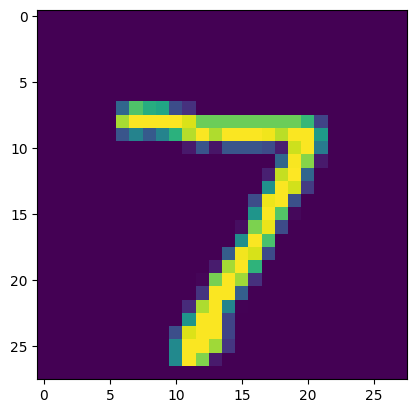

In [6]:
digit = []
for row in range(28):
    digit.append(batch_x[0][row])
digit = np.array(digit)
print(digit.shape)
plt.imshow(np.array(digit))

torch.Size([28, 28])
False


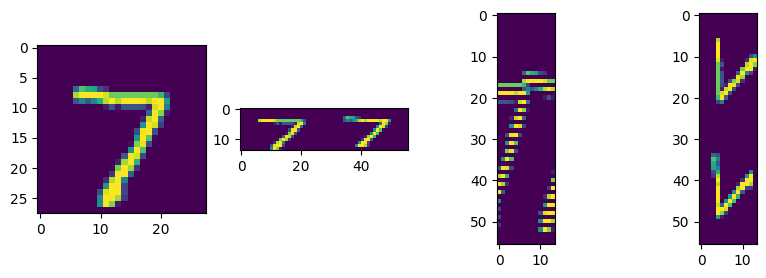

In [7]:
d = torch.tensor(digit)
print(d.shape)
n_row = 14
n_col = 56
d1 = d.view(n_row, n_col)
d2 = d.view(n_col, n_row)
print(torch.allclose(d1.t(), d2))

fig, axs = plt.subplots(1, 4, figsize=(1000*px, 300*px))
axs[0].imshow(d)
axs[1].imshow(d1)
axs[2].imshow(d2)
axs[3].imshow(d1.t())
plt.show()


In [8]:
from typing import Sequence

class RNNCell(nn.Module):
    @nn.compact
    def __call__(self, state, x):
        # Wh @ h + Wx @ x + b can be efficiently computed
        # by concatenating the vectors and then having a single dense layer
        x = jnp.concatenate([state, x])
        new_state = jnp.tanh(nn.Dense(state.shape[0], name='Dense_RNN')(x))
        out = jnp.tanh(nn.Dense(10, name='Dense_Out')(new_state))
        return new_state, (new_state, out)
    
class RNNLayer(nn.Module):
    hidden_size: int

    @nn.compact
    def __call__(self, x):
        scan_RNNCell = nn.scan(
            RNNCell,
            variable_broadcast='params',
            split_rngs={'params': False},
            in_axes=0,
            out_axes=0,
        )
        rnn_cell = scan_RNNCell()
        state = jnp.zeros((self.hidden_size,))
        _, (state_hist, out_hist) = rnn_cell(state, x)
        return state_hist, out_hist

class RNN(nn.Module):
    hidden_size: int
    output_size: int
    n_layers: int

    @nn.compact
    def __call__(self, x):
        rnn_cells = [RNNLayer(self.hidden_size) for _ in range(self.n_layers)]
        # print(x.shape)
        all_state_hist = []
        for id_layer, rnn_cell in enumerate(rnn_cells[:-1]):
            x, _ = rnn_cell(x)
            all_state_hist.append(x)
        state_hist, out_hist = rnn_cells[-1](x)
        all_state_hist.append(state_hist)
        return all_state_hist, out_hist
    
BatchRNN = nn.vmap(RNN, in_axes=0, out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})


In [9]:
srn = BatchRNN(256, 10, 3)
params = srn.init(jax.random.PRNGKey(0), jnp.zeros_like(batch_x[:5]))
all_state_hist, out_hist = srn.apply(params, batch_x[:5])
print(len(all_state_hist), all_state_hist[0].shape, all_state_hist[1].shape, all_state_hist[2].shape, out_hist.shape) # (batch, time, cell_size)
y = out_hist.mean(axis=1)
print(y.shape)
assert y.shape == (5, 10)
print(y)

3 (5, 28, 256) (5, 28, 256) (5, 28, 256) (5, 28, 10)
(5, 10)
[[-0.056  0.203 -0.454 -0.033  0.571  0.457  0.279  0.153  0.075  0.514]
 [ 0.032  0.2   -0.381 -0.117  0.58   0.449  0.305  0.208  0.073  0.496]
 [-0.079  0.244 -0.463 -0.055  0.623  0.488  0.296  0.198  0.11   0.529]
 [ 0.037  0.14  -0.37  -0.081  0.457  0.37   0.265  0.12   0.067  0.501]
 [-0.092  0.114 -0.433 -0.01   0.475  0.387  0.257  0.1    0.017  0.445]]


In [10]:
one_hot = jax.nn.one_hot(batch_y[:5], 10)
loss = optax.softmax_cross_entropy(logits=y, labels=one_hot)
print(loss.shape)
print(loss)
print(loss.mean())


(5,)
[2.361 2.905 2.294 2.446 1.987]
2.3984244


In [11]:
print(params['params'].keys())
print(params['params']['RNNLayer_0'].keys())
print(params['params']['RNNLayer_0']['ScanRNNCell_0'].keys())

print('\nparams: \n', jax.tree_util.tree_map(jnp.shape, params['params']))

# assert params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_Out']['kernel'].shape == (256, 10)
# assert params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_Out']['bias'].shape == (10,)
# assert params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_RNN']['kernel'].shape == (257, 256)
# assert params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_RNN']['bias'].shape == (256,)

dict_keys(['RNNLayer_0', 'RNNLayer_1', 'RNNLayer_2'])
dict_keys(['ScanRNNCell_0'])
dict_keys(['Dense_Out', 'Dense_RNN'])

params: 
 {'RNNLayer_0': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (284, 256)}}}, 'RNNLayer_1': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (512, 256)}}}, 'RNNLayer_2': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (512, 256)}}}}


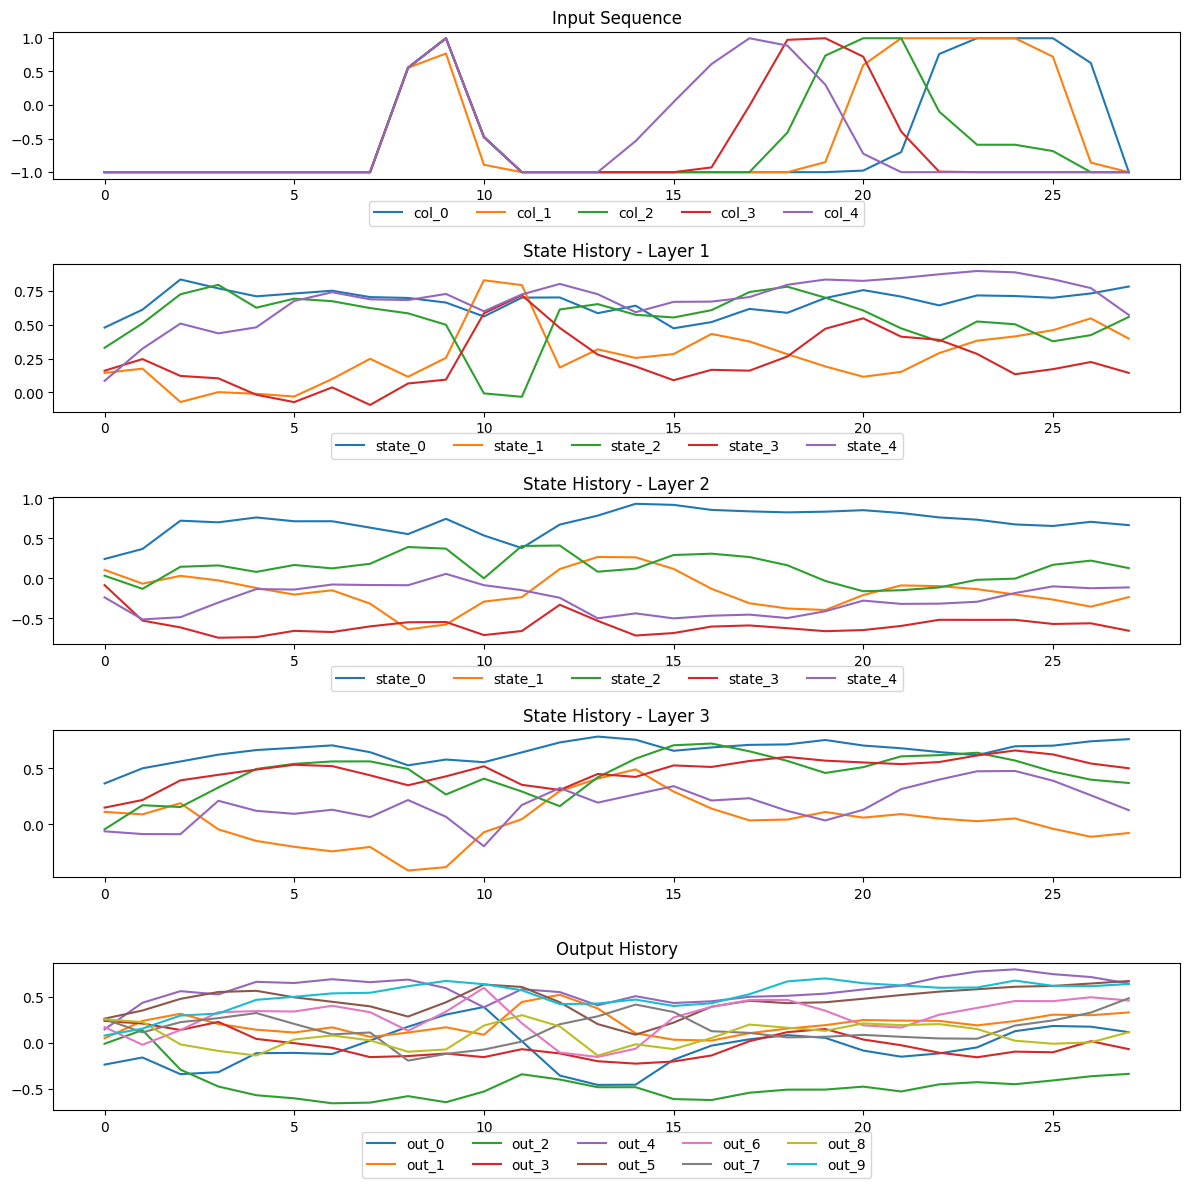

In [12]:

t = jnp.arange(784) if dataset_version == "sequential" else jnp.arange(28)

nb_inputs_to_plot = 5
nb_components_to_plot = 5
fig, axs = plt.subplots(5, 1, figsize=(1200*px, 1200*px))
labels_input = [f'pixel_{i}' for i in range(784)] if dataset_version == "sequential" else [f'col_{i}' for i in range(nb_inputs_to_plot)]
axs[0].plot(t, batch_x[0, :, 14-nb_inputs_to_plot//2:14+(nb_inputs_to_plot+1)//2], label=labels_input)
axs[0].set_title('Input Sequence')
axs[0].legend(ncol=14, loc='upper center', bbox_to_anchor=(0.5, -0.1))
axs[1].plot(t, all_state_hist[0][0, :, :nb_components_to_plot], label=[f'state_{i}' for i in range(nb_components_to_plot)])
axs[1].set_title('State History - Layer 1')
legend_ncol = 5 if nb_components_to_plot > 5 else nb_components_to_plot
axs[1].legend(ncol=legend_ncol, loc='upper center', bbox_to_anchor=(0.5, -0.1))
axs[2].plot(t, all_state_hist[1][0, :, :nb_components_to_plot], label=[f'state_{i}' for i in range(nb_components_to_plot)])
axs[2].set_title('State History - Layer 2')
axs[2].legend(ncol=legend_ncol, loc='upper center', bbox_to_anchor=(0.5, -0.1))
axs[3].plot(t, all_state_hist[2][0, :, :nb_components_to_plot], label=[f'state_{i}' for i in range(nb_components_to_plot)])
axs[3].set_title('State History - Layer 3')
axs[-1].plot(t, out_hist[0, :, :], label=[f'out_{i}' for i in range(10)])
axs[-1].set_title('Output History')
axs[-1].legend(ncol=5, loc='upper center', bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
plt.show()

In [13]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
lr = 1e-3

In [14]:
@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

In [15]:
def apply_model(state, images, labels):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params):
        _, out_hist = state.apply_fn({'params': params}, images)
        logits = out_hist.mean(axis=1)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy
    

In [16]:
def run_epoch(state, train_dl, rng):
    """Train for a single epoch."""

    epoch_loss = []
    epoch_accuracy = []

    progress_bar = tqdm(train_dl, desc="Training", leave=True)
    batch_id = 0
    for batch_images, batch_labels in progress_bar:
        grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
        # print(jnp.max(grads['dense_0']['kernel']), jnp.min(grads['dense_0']['kernel']))
        # print(loss)
        state = update_model(state, grads)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
        batch_id += 1
        if batch_id % 3 == 0:
            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy.item())
        
    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)
    return state, train_loss, train_accuracy


In [17]:
def create_train_state(key, model_cls, lr, dataset_version):
    
    init_x = jnp.ones((128, 784, 1)) if dataset_version == "sequential" else jnp.ones((128, 28, 28))

    model = model_cls(hidden_size=256, output_size=10, n_layers=3)
    params = model.init(key, init_x)['params']
    
    # Debugging: Print parameter structure
    print("Initialized parameter structure:", jax.tree_util.tree_map(jnp.shape, params))

    optimizer = optax.adam(lr)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )


In [18]:
state = create_train_state(key, BatchRNN, lr, dataset_version)

Initialized parameter structure: {'RNNLayer_0': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (284, 256)}}}, 'RNNLayer_1': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (512, 256)}}}, 'RNNLayer_2': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (512, 256)}}}}


We can see that 1 epoch takes ~2min with this scan version.
The vanilla version takes ~2min for 10 batches --> 92 min / epoch.

In [20]:
for epoch in range(1):
    state, train_loss, train_accuracy = run_epoch(state, trainloader, key)
    print(f"Epoch {epoch} | Loss: {train_loss} | Accuracy: {train_accuracy}")

Training:   6%|▌         | 26/468 [00:31<08:57,  1.22s/it, accuracy=0.492, loss=1.91]


KeyboardInterrupt: 

In [12]:
key = jax.random.PRNGKey(0)

A = jax.random.normal(key, (10000, 10000))
B = jax.random.normal(key, (10000, 10000))

@jax.jit
def matmul(A, B):
    return jnp.dot(A, B)

# print(jax.profiler.start_trace())
for _ in range(1000):
    a = matmul(A, B)
# jax.profiler.save_trace("matmul.json")


KeyboardInterrupt: 

In [19]:
all_state_hist, out_hist = srn.apply(params, batch_x[:5])
print([all_state_hist[i].shape for i in range(3)], out_hist.shape)

AttributeError: 'list' object has no attribute 'shape'

In [20]:
print(jax.tree_util.tree_map(jnp.shape, params['params']))
print(jax.tree_util.tree_map(jnp.shape, state.params))

{'RNNLayer_0': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (257, 256)}}}, 'RNNLayer_1': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (512, 256)}}}, 'RNNLayer_2': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (512, 256)}}}}
{'RNNLayer_0': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (257, 256)}}}, 'RNNLayer_1': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (512, 256)}}}, 'RNNLayer_2': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (512, 256)}}}}


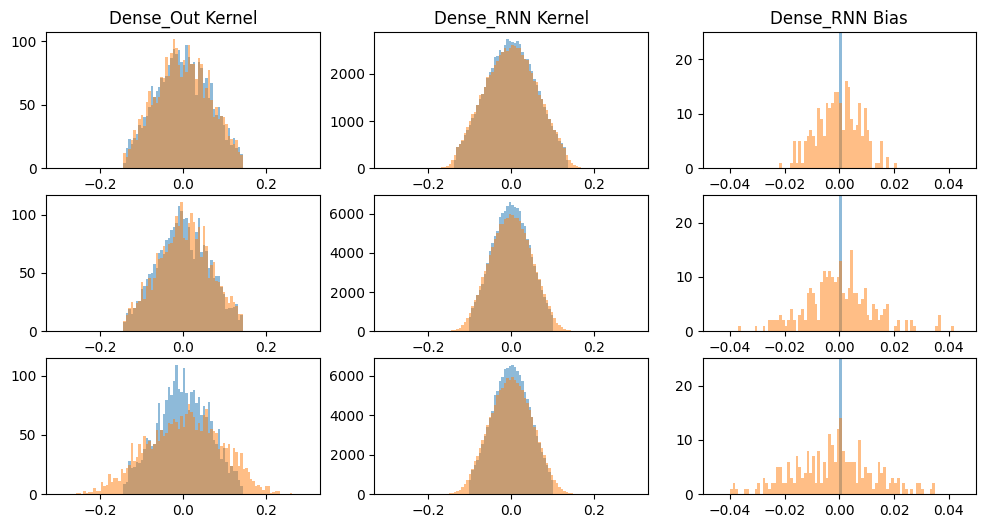

In [72]:
fig, axs = plt.subplots(3, 3, figsize=(1200*px, 600*px))
axs[0,0].set_title('Dense_Out Kernel')
axs[0,1].set_title('Dense_RNN Kernel')
axs[0,2].set_title('Dense_RNN Bias')
for l in range(3):
    axs[l,0].hist(params['params'][f'RNNLayer_{l}']['ScanRNNCell_0']['Dense_Out']['kernel'].flatten(), bins=100, alpha=0.5, range=(-0.3, 0.3))
    axs[l,1].hist(params['params'][f'RNNLayer_{l}']['ScanRNNCell_0']['Dense_RNN']['kernel'].flatten(), bins=100, alpha=0.5, range=(-0.3, 0.3))
    axs[l,2].hist(params['params'][f'RNNLayer_{l}']['ScanRNNCell_0']['Dense_RNN']['bias'].flatten(), bins=100, alpha=0.5, range=(-0.05, 0.05))
    axs[l,0].hist(state.params[f'RNNLayer_{l}']['ScanRNNCell_0']['Dense_Out']['kernel'].flatten(), bins=100, alpha=0.5, range=(-0.3, 0.3))
    axs[l,1].hist(state.params[f'RNNLayer_{l}']['ScanRNNCell_0']['Dense_RNN']['kernel'].flatten(), bins=100, alpha=0.5, range=(-0.3, 0.3))
    axs[l,2].hist(state.params[f'RNNLayer_{l}']['ScanRNNCell_0']['Dense_RNN']['bias'].flatten(), bins=100, alpha=0.5, range=(-0.05, 0.05))
    # set y range
    axs[l,2].set_xlim(-0.05, 0.05)
    axs[l,2].set_ylim(0, 25)
plt.show()